In [20]:
# 01_emissions_pareto.ipynb

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import yaml
from sqlalchemy import create_engine
# Load configuration file / Cargar archivo de configuración
with open("../config.yml", "r") as f:
    cfg = yaml.safe_load(f)

# Anchor paths to repo root (parent of notebooks/) / Anclar rutas a la raíz del repositorio (carpeta padre de notebooks/)
repo_root = Path.cwd().parent
clean_path = repo_root / cfg["paths"]["clean_data"]
spatial_path = repo_root / cfg["paths"]["spatial_data"]
stake_path = repo_root / cfg["paths"]["stakeholders"]

# Load datasets with utf-8-sig / Cargar datasets con utf-8-sig
income = pd.read_csv(stake_path / "renta_media_madrid.csv", sep=",", encoding="utf-8-sig") # Income data / Datos de renta

# Load spatial data (district shapefile) / Cargar datos espaciales (shapefile de distritos)
districts = gpd.read_file(spatial_path / "Distritos/DISTRITOS.shp")

In [21]:
# df_gei ) Greenhouse gas emissions load/ Emisiones GEI carga
df_gei = pd.read_csv(clean_path / "df_gei.csv", sep=",", encoding="utf-8-sig")
print(df_gei.info())
print(df_gei.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5885 entries, 0 to 5884
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gei_yr         5885 non-null   int64  
 1   gei_crf        5885 non-null   object 
 2   gei_co2_eq_t   5885 non-null   float64
 3   gei_pollutant  5885 non-null   object 
dtypes: float64(1), int64(1), object(2)
memory usage: 184.0+ KB
None
   gei_yr gei_crf  gei_co2_eq_t gei_pollutant
0    1990    1A1a     15.104735           N2O
1    1990    1A1a     15.959580           CH4


In [22]:
# Descriptive / Descriptiva
df_gei.describe(include = "all")

,gei_yr,gei_crf,gei_co2_eq_t,gei_pollutant
count,5885.000000,5885,5.885000e+03,5885
unique,NaN,128,NaN,6
top,NaN,2F1c,NaN,CO2
freq,NaN,203,NaN,2063
mean,2006.516907,NaN,1.294547e+05,NaN
std,9.424857,NaN,8.062101e+05,NaN
min,1990.000000,NaN,-5.749152e+05,NaN
25%,1999.000000,NaN,5.971818e+01,NaN
50%,2007.000000,NaN,2.203714e+03,NaN
75%,2015.000000,NaN,1.889338e+04,NaN


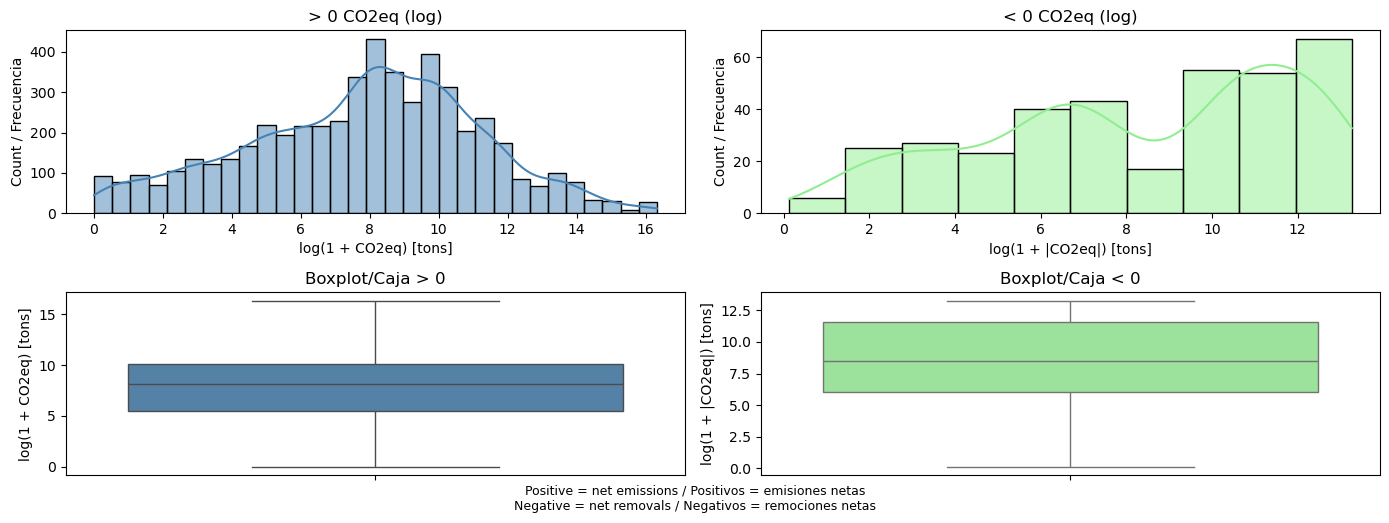

In [23]:
# --- Split data / Dividir datos ---
pos = df_gei.loc[df_gei["gei_co2_eq_t"] > 0, "gei_co2_eq_t"]   # positives / positivos
neg = df_gei.loc[df_gei["gei_co2_eq_t"] < 0, "gei_co2_eq_t"]   # negatives / negativos

# --- Log-transform / Transformación log ---
pos_log = np.log1p(pos)     # log(1+x) for positives / para positivos
neg_log = np.log1p(-neg)    # log(1+|x|) for negatives / para negativos

# --- Plots / Gráficos ---
fig, axes = plt.subplots(2, 2, figsize=(14, 5))

# Histogram positives / Histograma positivos
sns.histplot(pos_log, bins='auto', kde=True, color="steelblue", ax=axes[0,0])
axes[0,0].set_title("> 0 CO2eq (log)")
axes[0,0].set_xlabel("log(1 + CO2eq) [tons]"); axes[0,0].set_ylabel("Count / Frecuencia")

# Histogram negatives / Histograma negativos
sns.histplot(neg_log, bins='auto', kde=True, color="lightgreen", ax=axes[0,1])
axes[0,1].set_title("< 0 CO2eq (log)")
axes[0,1].set_xlabel("log(1 + |CO2eq|) [tons]"); axes[0,1].set_ylabel("Count / Frecuencia")

# Boxplot positives / Caja positivos
sns.boxplot(y=pos_log, color="steelblue", ax=axes[1,0])
axes[1,0].set_title("Boxplot/Caja > 0")
axes[1,0].set_ylabel("log(1 + CO2eq) [tons]")

# Boxplot negatives / Caja negativos
sns.boxplot(y=neg_log, color="lightgreen", ax=axes[1,1])
axes[1,1].set_title("Boxplot/Caja < 0")
axes[1,1].set_ylabel("log(1 + |CO2eq|) [tons]")

# Note / Nota
fig.text(0.5, -0.03,
         "Positive = net emissions / Positivos = emisiones netas\n"
         "Negative = net removals / Negativos = remociones netas",
         ha="center", fontsize=9)
plt.tight_layout()
plt.show()

| Concept                  | Explanation                                                                 | Explicación                                                          |
|--------------------------|--------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| CO₂eq (CO₂ equivalent)   | Combines all greenhouse gases (methane, nitrous oxide, etc) into one value based on their global warming potential (GWP). | Combina todos los gases de efecto invernadero en un solo valor según su potencial de calentamiento global (GWP). |
| Why use CO₂eq?           | To compare gases like methane or nitrous oxide as if they were CO₂.                 | Para comparar gases como metano o óxidos de nitrógeno como si fueran CO₂.             |
| Example                  | 1 ton of methane ≈ 25 tons of CO₂eq.                                                | 1 tonelada de metano ≈ 25 toneladas de CO₂eq.                                         |
| Negative CO₂eq values    | Indicate net carbon removal (e.g. forests absorbing more CO₂ than they emit).       | Indican remoción neta de carbono (ej. bosques absorbiendo más CO₂ del que emiten).   |
| Where negatives appear   | Common in land use, forestry, or carbon offset sectors.                             | Común en sectores de uso del suelo, silvicultura o compensaciones de carbono.         |
| What to check            | Lets look at sector_crf or category_crf to understand the source of negative values.     | Revisar sector_crf o category_crf para entender el origen de los valores negativos.    |

In [24]:
# --- Collapse emissions by CRF sector / Agrupar emisiones por sector CRF ---

# Step 1. Define CRF prefix-to-sector map / Definir mapa de prefijos CRF a sectores
crf_map = {
    "1": "Energy",        # Energía
    "2": "Industry",      # Industria
    "3": "Agriculture",   # Agricultura
    "4": "Land Uses",     # Usos del suelo
    "5": "Waste",         # Residuos
    "6": "Other",         # Otros
}
# Step 2. Extract sector code from CRF / Extraer código de sector del CRF
df_gei["crf_sector"] = df_gei["gei_crf"].str.extract(r"^(\d)")  # e.g. '1A1a' → '1'

# Step 3. Map to broad sector / Mapear a sector amplio
df_gei["sector_group"] = df_gei["crf_sector"].map(crf_map).fillna("Other")

# Step 4. Sum emissions by sector / Sumar emisiones por sector
summary = df_gei.groupby("sector_group")["gei_co2_eq_t"].sum()

# Step 5. Sort by absolute emissions / Ordenar por emisiones absolutas
summary = summary.reindex(summary.abs().sort_values(ascending=False).index)

# --- Format totals with Spanish-style separators / Formatear totales con separadores estilo español ---
summary_fmt = summary.apply(lambda x: f"{x:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."))  # English / Español
summary_fmt

sector_group
Energy         651.263.619,91
Waste           63.067.766,90
Industry        62.436.475,74
Land Uses      -24.462.637,14
Agriculture      9.535.677,39
Name: gei_co2_eq_t, dtype: object

| Group              | Description                                   | Descripción                                   | CO₂eq [tons]    |
|--------------------|-----------------------------------------------|-----------------------------------------------|---------------|
| Energy             | Combustion, leaks                             | Combustión, fugas                             | 651.263.619,91 t   |
| Industry           | F-gases, minerals, metals, solvents           | Gases fluorados, minerales, metales, disolventes | 62.436.475,74 t     |
| Agriculture        | Livestock, soils, manure, rice, burning       | Ganado, suelos, estiércol, arroz, quema       | 9,535.677,39 t      |
| Waste              | Landfills, wastewater, incineration           | Vertederos, aguas residuales, incineración    | 63.067.766,90 t     |
| Land Uses (LULUCF) | Forests, cropland, grassland, wetlands, wood products | Bosques, cultivos, pastizales, humedales, madera | -24.462.637,14 t    |

C:\Users\LAP-MPC\AppData\Local\Temp\ipykernel_14244\590061022.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()  # remove legend


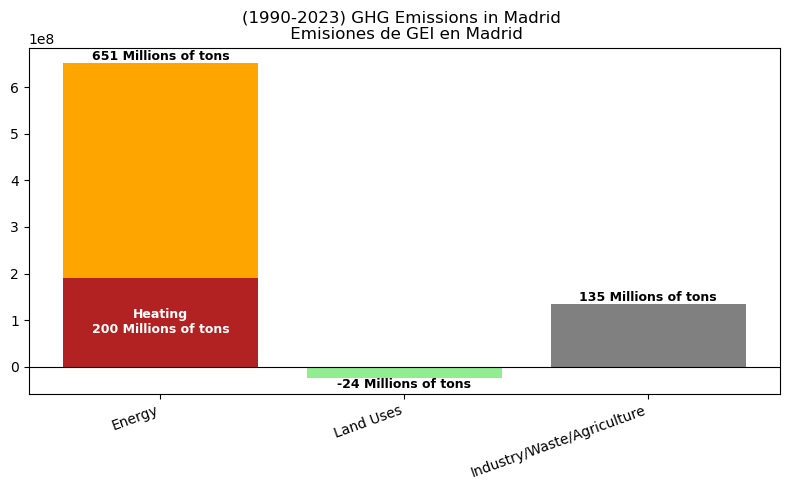

In [25]:
import matplotlib.pyplot as plt

# --- Define Heating CRF codes / Definir códigos CRF de calefacción ---
heating_crfs = ["1A1a", "1A4a", "1A4b", "1A4c"]
df_gei["is_heating"] = df_gei["gei_crf"].isin(heating_crfs)

# --- Collapse into 3 groups / Agrupar en 3 grupos ---
def collapse_group(sector):
    if sector == "Energy":
        return "Energy"
    elif sector == "Land Uses":
        return "Land Uses"
    elif sector in ["Industry", "Waste", "Agriculture"]:
        return "Industry/Waste/Agriculture"
    else:
        return "Other"

df_gei["group3"] = df_gei["sector_group"].map(collapse_group)

# --- Totals / Totales ---
summary3 = df_gei.groupby("group3")["gei_co2_eq_t"].sum()
energy_total = summary3["Energy"]
heating_total = df_gei[df_gei["is_heating"]]["gei_co2_eq_t"].sum()
other_energy = energy_total - heating_total

# --- Build data / Construir datos ---
bars = {
    "Energy": (heating_total, other_energy),
    "Land Uses": (summary3["Land Uses"],),
    "Industry/Waste/Agriculture": (summary3["Industry/Waste/Agriculture"],)
}

# --- Plot / Graficar ---
plt.figure(figsize=(8,5))

# Energy stacked
plt.bar("Energy", bars["Energy"][0], color="firebrick")
plt.bar("Energy", bars["Energy"][1], bottom=bars["Energy"][0], color="orange")

# Land Uses
plt.bar("Land Uses", bars["Land Uses"][0], color="lightgreen")

# Industry/Waste/Agriculture
plt.bar("Industry/Waste/Agriculture", bars["Industry/Waste/Agriculture"][0], color="gray")

# Horizontal line at zero
plt.axhline(0, color="black", linewidth=0.8)

# --- Labels inside and on top / Etiquetas internas y superiores ---
# Heating inside red bar
plt.text(0, bars["Energy"][0]/2, "Heating\n200 Millions of tons",
         ha="center", va="center", color="white", fontsize=9, fontweight="bold")

# Totals on top of bars
totals = {
    "Energy": round(energy_total/1_000_000),
    "Land Uses": round(summary3["Land Uses"]/1_000_000),
    "Industry/Waste/Agriculture": round(summary3["Industry/Waste/Agriculture"]/1_000_000)
}
for i, (grp, val) in enumerate(totals.items()):
    label = f"{val} Millions of tons"
    if val >= 0:
        plt.text(i, summary3[grp], label, ha="center", va="bottom", fontsize=9, fontweight="bold")
    else:
        plt.text(i, summary3[grp], label, ha="center", va="top", fontsize=9, fontweight="bold")

# --- Style / Estilo ---
plt.xticks(rotation=20, ha="right")
plt.title("(1990-2023) GHG Emissions in Madrid \n Emisiones de GEI en Madrid")
plt.xlabel("")
plt.legend().remove()  # remove legend

plt.tight_layout()
plt.show()

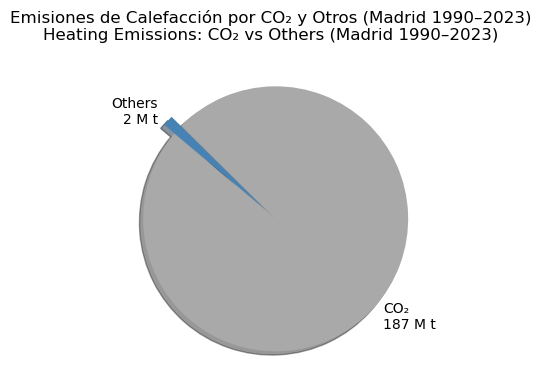

In [26]:


# --- Define Heating CRF codes / Definir códigos CRF de calefacción ---
heating_crfs = ["1A1a", "1A4a", "1A4b", "1A4c"]

# --- Filter Heating rows / Filtrar filas de calefacción ---
df_heating = df_gei[df_gei["gei_crf"].isin(heating_crfs)]

# --- Split into CO₂ vs Others / Dividir en CO₂ vs Otros ---
co2_total = df_heating[df_heating["gei_pollutant"] == "CO2"]["gei_co2_eq_t"].sum()
others_total = df_heating[df_heating["gei_pollutant"] != "CO2"]["gei_co2_eq_t"].sum()

# --- Data for pie chart / Datos para gráfico de torta ---
sizes = [co2_total, others_total]
labels = [
    f"CO₂\n{round(co2_total/1_000_000)} M t",
    f"Others\n{round(others_total/1_000_000)} M t"
]
colors = ["darkgrey", "steelblue"]

# --- Pie chart / Gráfico de torta ---
plt.figure(figsize=(4,4))
plt.pie(
    sizes,
    labels=labels,
    colors=colors,
    explode=(0.05, 0.05),   # small separation for 3D effect
    shadow=True,
    startangle=140
)

plt.title("Emisiones de Calefacción por CO₂ y Otros (Madrid 1990–2023)\nHeating Emissions: CO₂ vs Others (Madrid 1990–2023)")
plt.tight_layout()
plt.show()


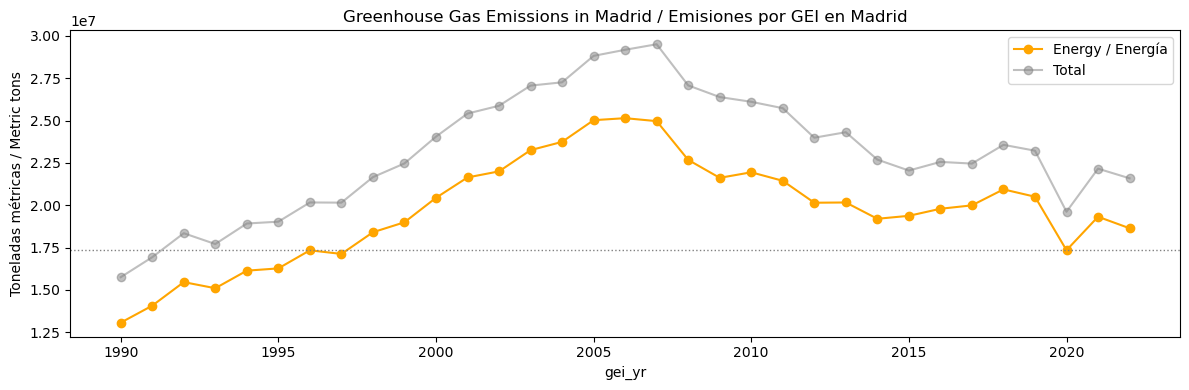

In [27]:
# --- Energy vs Total per year in full metric tons / Energía vs Total por año en toneladas métricas completas ---

# Step 1: Group by year and sector_group / Agrupar por año y sector
yearly = df_gei.groupby(["gei_yr", "sector_group"])["gei_co2_eq_t"].sum().reset_index()

# Step 2: Pivot to wide format / Convertir a formato ancho
wide = yearly.pivot(index="gei_yr", columns="sector_group", values="gei_co2_eq_t").fillna(0)

# Step 3: Extract Energy and Total / Extraer Energía y Total
energy = wide["Energy"]
total = wide.sum(axis=1)

# Step 4: Plot / Graficar
plt.figure(figsize=(12, 4))
energy.plot(marker="o", color="orange", label="Energy / Energía")
total.plot(marker="o", color="gray", alpha=0.5, label="Total")

# Horizontal line at 2020 / Línea horizontal en 2020
if 2020 in energy.index:
    y2020 = energy.loc[2020]
    plt.axhline(y=y2020, color="grey", linestyle="dotted", linewidth=1)

plt.title("Greenhouse Gas Emissions in Madrid / Emisiones por GEI en Madrid")
plt.ylabel("Toneladas métricas / Metric tons")
plt.legend()
plt.tight_layout()
plt.show()

##  Energy CO₂eq vs Total — Interpretation / Interpretación

| Año clave | Explanation                                                              | Explicación                                                                |
|-----------|----------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------|
| 2007–2008 | Total emissions peak, then begin gradual decline. Energy emissions follow but lag.    | Las emisiones totales alcanzan su punto máximo y luego comienzan a descender. Energía sigue, pero con retraso. |
| 2019      | Energy emissions drop sharply, diverging from previous trend.                         | Las emisiones de energía caen bruscamente, rompiendo la tendencia anterior.             |
| 2020      | COVID-19 lockdowns reduce mobility, industrial activity, and heating demand.          | Los confinamientos por COVID-19 reducen movilidad, actividad industrial y demanda de calefacción. |
| Post-2020 | Signals a structural shift: remote work, energy efficiency, and decarbonization gain traction. | Señala un cambio estructural: teletrabajo, eficiencia energética y descarbonización ganan impulso. |

---

###  Stakeholder Implications / Implicaciones para actores clave

| Sector / Stakeholder       | English Impact Summary                                                  | Resumen de impacto en español                                                  |
|----------------------------|--------------------------------------------------------------------------|---------------------------------------------------------------------------------|
| Government / Gobierno      | Policy momentum shifts toward green recovery and climate targets.       | El impulso político se orienta hacia recuperación verde y metas climáticas.    |
| Industry / Industria       | Pressure to decarbonize operations, electrify heating, and report GEI.  | Presión para descarbonizar, electrificar calefacción y reportar GEI.           |
| Investors / Inversores     | Funding flows into renewables, building retrofits, and low-carbon tech. | Flujos de inversión hacia renovables, rehabilitación y tecnología baja en carbono. |
| Citizens / Ciudadanía      | Behavioral shifts (remote work, energy use) become part of climate action. | Cambios de comportamiento (teletrabajo, uso energético) se integran en la acción climática. |

---

###  What This Chart Means / Qué significa este gráfico

- **The 2020 drop is not just noise** — it reflects a real disruption in energy-related emissions.
- **Post-COVID recovery opens a window** for structural changes in heating, transport, and building efficiency.
- **Stakeholders** The rise in Spain after 1990 reflects urbanization, increased mobility, expanded energy demand in buildings, and a shift toward fossil-based heating — even as housing construction slowed in recent years. The sharp drop around 2020 is almost certainly COVID: lockdowns, reduced transport, lower industrial output, and less heating in offices. That drop is a signal — not just of disruption, but of opportunity. It shows how fast emissions can fall when systems pause. For policymakers and stakeholders, it’s proof that structural change is possible. It opens the door to funding retrofits, electrifying heating, and accelerating decarbonization.

In [28]:
# df_pst) Particulate matter / Material particulado
df_pst = pd.read_csv(clean_path / "pst.csv", sep=",", encoding="utf-8-sig") 
print(df_pst.info())
print(df_pst.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              264 non-null    int64 
 1   emission_concept  264 non-null    object
 2   tons_pst          264 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 6.3+ KB
None
   year                                   emission_concept  tons_pst
0  2000  Emisión de partículas en suspensión en otras f...       830
1  2000          Total emisión de partículas en suspensión     18926


In [29]:
# Descriptive / Descriptiva
print(df_pst.describe())

              year      tons_pst
count   264.000000    264.000000
mean   2010.500000   2591.306818
std       6.356339   4639.757009
min    2000.000000      0.000000
25%    2005.000000    281.000000
50%    2010.500000    714.500000
75%    2016.000000   2493.750000
max    2021.000000  24158.000000


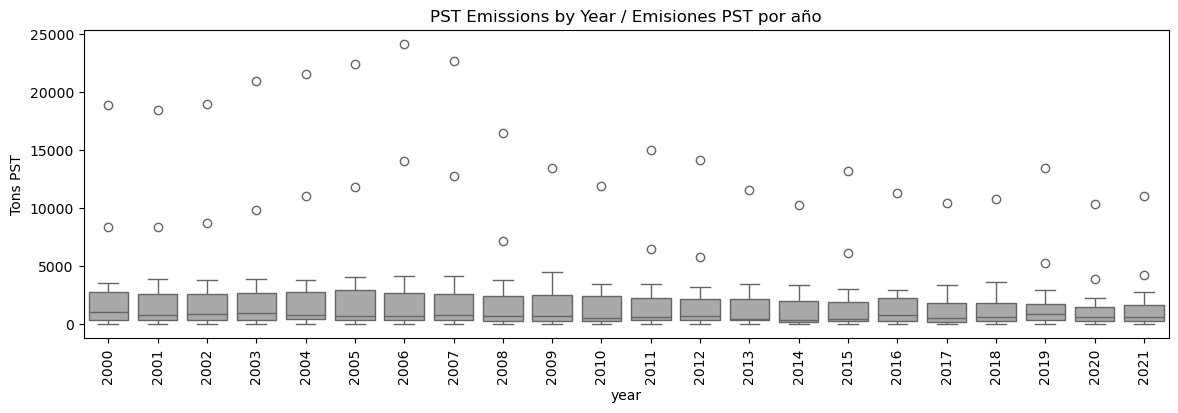

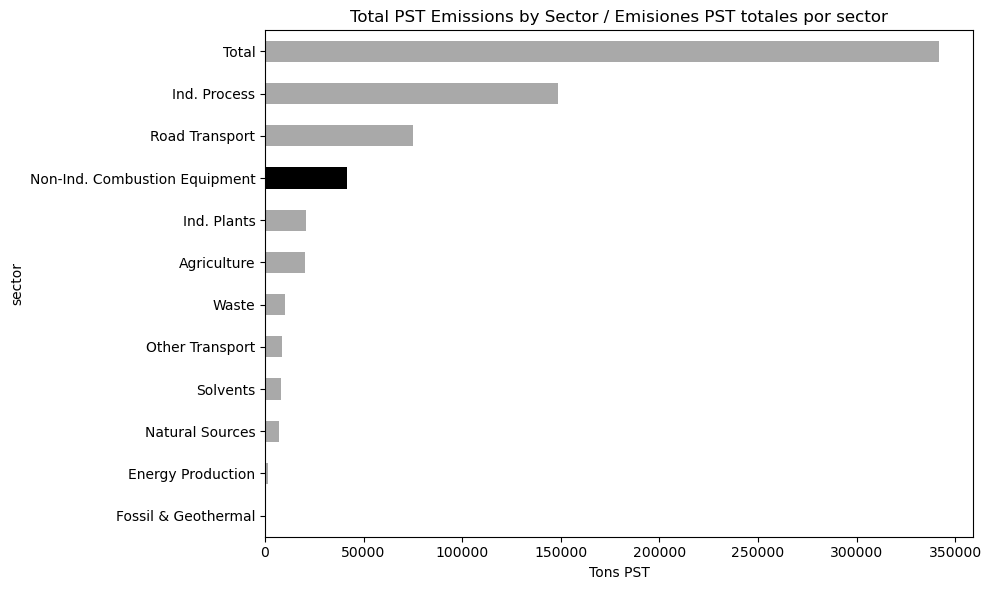

In [30]:
# --- Full mapping dictionary / Diccionario completo de mapeo ---
map_dict = {
    "Total emisión de partículas en suspensión": "Total",
    "Emisión de partículas en suspensión en procesos industriales en combustión": "Ind. Combustion",
    "Emisión de partículas en suspensión en procesos industriales sin combustión": "Ind. Process",
    "Emisión de partículas en suspensión en el transporte por carretera": "Road Transport",
    "Emisión de partículas en suspensión en plantas de combustión no industrial": "Non-Ind. Combustion Equipment",
    "Emisión de partículas en suspensión en plantas de combustión industrial": "Ind. Plants",
    "Emisión de partículas en suspensión en el uso de disolventes y otros productos": "Solvents",
    "Emisión de partículas en suspensión en la agricultura y silvicultura": "Agriculture",
    "Emisión de partículas en suspensión en agricultura": "Agriculture",
    "Emisión de partículas en suspensión en tratamiento de aguas residuales y residuos": "Waste",
    "Emisión de partículas en suspensión en el tratamiento y eliminación de residuos": "Waste",
    "Emisión de partículas en suspensión en el uso de productos fluorados": "Fluorinated",
    "Emisión de partículas en suspensión en la extracción y distribución de combustibles fósiles y energía geotérmica": "Fossil & Geothermal",
    "Emisión de partículas en suspensión en otras fuentes": "Other",
    "Emisión de partículas en suspensión en otras fuentes y sumideros (naturaleza)": "Natural Sources",
    "Emisión de partículas en suspensión en la combustión en la producción y transformación de energía": "Energy Production",
    "Emisión de partículas en suspensión en otros modos de transporte y maquinaria móvil": "Other Transport"
}

# --- Apply mapping / Aplicar mapeo ---
df_pst["sector"] = df_pst["emission_concept"].map(map_dict).fillna(df_pst["emission_concept"])

# --- 1. Boxplot PST by year / Diagrama de caja por año ---
plt.figure(figsize=(14,4))
sns.boxplot(x="year", y="tons_pst", data=df_pst, color="darkgrey")  # dark grey boxes
plt.xticks(rotation=90)
plt.title("PST Emissions by Year / Emisiones PST por año")
plt.ylabel("Tons PST")
plt.show()

# --- 2. Total emissions by sector / Emisiones totales por sector ---
totals = df_pst.groupby("sector")["tons_pst"].sum().sort_values()

# Build color list: default darkgrey, highlight Non-Ind. Combustion in black
colors = ["black" if s == "Non-Ind. Combustion Equipment" else "darkgrey" for s in totals.index]

plt.figure(figsize=(10,6))
totals.plot.barh(color=colors)
plt.title("Total PST Emissions by Sector / Emisiones PST totales por sector")
plt.xlabel("Tons PST")
plt.tight_layout()
plt.show()

| Aspect / Aspecto        | English Summary                                                                 | Resumen en Español                                                                 |
|--------------------------|---------------------------------------------------------------------------------|------------------------------------------------------------------------------------|
| Yearly Boxplot           | Shows PST emissions fluctuating 2000–2021 with visible outliers. Indicates episodic spikes tied to heating demand or industrial activity. | Muestra fluctuaciones de emisiones PST entre 2000–2021 con picos atípicos. Refleja eventos puntuales ligados a la demanda de calefacción o actividad industrial. |
| Sector Bar Chart         | Highlights Non-Industrial Combustion (heating), Road Transport, and Industrial Combustion as dominant sources. Overlaps with energy CO₂eq emissions in df_gei. | Evidencia que la combustión no industrial (calefacción), el transporte por carretera y la combustión industrial son las principales fuentes. Coinciden con sectores que generan CO₂eq en df_gei. |
| Policy Relevance         | Heating is a dual-problem sector: reducing heating emissions lowers both CO₂eq (climate) and PST (air quality/health). | La calefacción es un sector crítico: reducir sus emisiones disminuye tanto CO₂eq (clima) como PST (salud y calidad del aire). |
| Stakeholder – Municipalities | Justify heating retrofits as climate + health policy. | Justificar programas de rehabilitación energética como política climática y sanitaria. |
| Stakeholder – Investors  | Double ROI: emissions reduction + public health benefit. | Retorno doble: reducción de emisiones + beneficio sanitario. |
| Stakeholder – Citizens   | Cleaner winter air, fewer respiratory issues. | Aire más limpio en invierno, menos problemas respiratorios. |
| Stakeholder – EU/Regulators | Compliance with climate and air quality directives. | Cumplimiento de directivas de clima y calidad del aire. |

In [31]:
# df_ceee Energy efficiency certificates / Certificados de eficiencia energética
df_ceee = pd.read_csv(clean_path / "ceee.csv", sep=",", encoding="utf-8-sig") 
print(df_ceee.info())
print(df_ceee.head(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55717 entries, 0 to 55716
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   e_postal_code               55717 non-null  int64  
 1   ceee_date                   55716 non-null  object 
 2   e_year_built                55717 non-null  float64
 3   e_surface_m2                55717 non-null  float64
 4   e_compactness_m3_m2         55717 non-null  float64
 5   e_pct_surface_heated        55717 non-null  float64
 6   e_heating_type              50209 non-null  object 
 7   e_heating_vector            50210 non-null  object 
 8   e_heating_demand_kwh_m2_a   55717 non-null  float64
 9   final_heating_kwh_m2_a      55717 non-null  float64
 10  nonren_heating_kwh_m2_a     55717 non-null  float64
 11  nonren_co2_heating_kg_m2_a  55717 non-null  float64
 12  e_hot_water_type            54512 non-null  object 
 13  e_hotwater_demand_kwh_m2_a  557

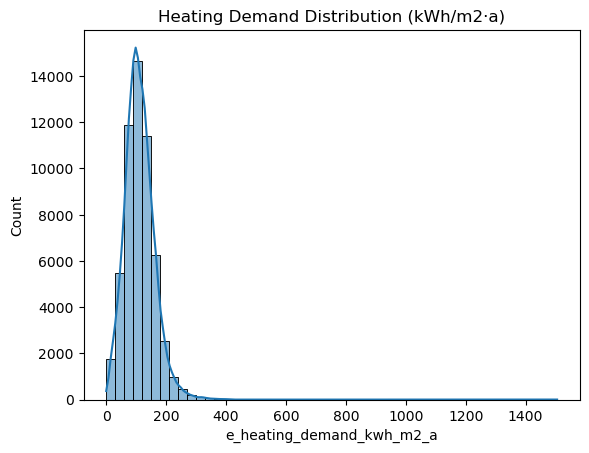

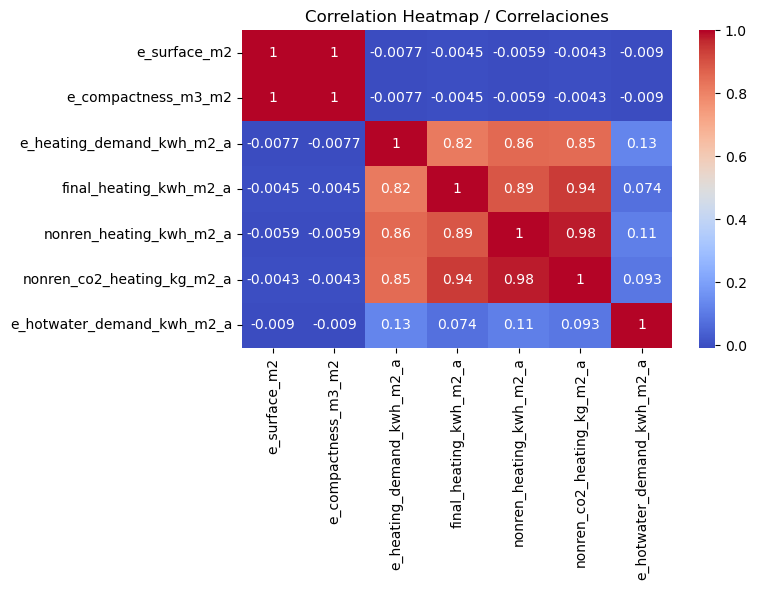

In [32]:
# CEEE: heating demand / demanda de calefacción
sns.histplot(df_ceee["e_heating_demand_kwh_m2_a"], bins=50, kde=True)
plt.title("Heating Demand Distribution (kWh/m2·a)")
plt.show()

# Correlation: heating demand vs non-renewable CO2 / correlación demanda de calefacción vs CO2 no renovable

# --- Define numeric columns / Definir columnas numéricas ---
num_cols = [
    "e_surface_m2",
    "e_compactness_m3_m2",
    "e_heating_demand_kwh_m2_a",
    "final_heating_kwh_m2_a",
    "nonren_heating_kwh_m2_a",
    "nonren_co2_heating_kg_m2_a",
    "e_hotwater_demand_kwh_m2_a"
]

# --- Compute correlation matrix / Calcular matriz de correlación ---
corr = df_ceee[num_cols].corr()

# --- Create figure and axis / Crear figura y eje ---
fig, ax = plt.subplots(figsize=(8,6))

# --- Plot heatmap with coolwarm palette / Graficar mapa de calor con paleta coolwarm ---
sns.heatmap(corr, annot=True, cmap="coolwarm", ax=ax)

# --- Title / Título ---
ax.set_title("Correlation Heatmap / Correlaciones")

plt.tight_layout()
plt.show()

## Strong correlations = clear causal chain

Heating demand (**kWh/m²·year**) is strongly correlated with:
- Final heating energy (**r = 0.82**)
- Non‑renewable CO₂ emissions (**r = 0.85**)

This means inefficient buildings directly translate into higher CO₂ emissions.  
There’s no ambiguity: the more energy a building needs for heating, the more fossil energy it consumes, and the more CO₂ it emits.

---


## Policy leverage point: heating

- In **df_gei**, the Energy sector CO₂eq was the main driver of total emissions.
- In **df_pst**, Non‑Industrial Combustion (heating) was a dominant source of particulate matter.
- In **df_ceee**, heating demand is the direct predictor of CO₂ intensity., root cause.

Together, these datasets converge on the same conclusion:  
**Heating is the common denominator for climate and health impacts.**
**Inefficient heating is the bottleneck, and fixing it delivers triple wins (climate, health, cost).**
---

## Stakeholder implications

- **Municipalities (Madrid, Germany):** can justify building retrofit programs as dual‑benefit (CO₂ + air quality).
- **Investors / EU funds:** see heating retrofits as high‑impact, measurable interventions.
- **Citizens:** benefit from lower bills and cleaner winter air.
- **Regulators:** can align climate targets with EU air quality directives.
- Targeting heating efficiency and electrification is the single most impactful policy lever.

In [33]:
# load Gas dataset 
gas = pd.read_csv(clean_path / "gas.csv", sep=",", encoding="utf-8-sig") # Gas consumption / Consumo de gas

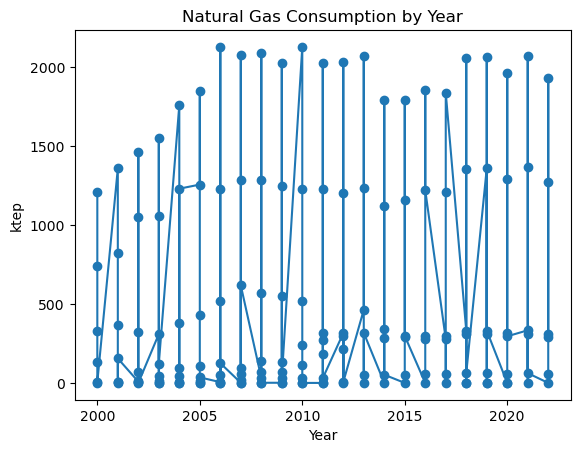

In [34]:
# Gas: consumption trend / tendencia de consumo de gas
plt.plot(gas["natural_gas_consumption_yr"], gas["natural_gas_ktep"], marker="o")
plt.title("Natural Gas Consumption by Year")
plt.xlabel("Year")
plt.ylabel("ktep")
plt.show()

## Gas consumption trend (df_gas)

**EN:** Natural gas use in Spain shows fluctuations from 2000–2022. Key drops align with energy shifts. Use df_gas to support fossil heating phase-out and CO₂ modeling.

**ES:** El uso de gas natural en España varía entre 2000–2022. Las caídas clave reflejan cambios energéticos. Usa df_gas para modelar calefacción fósil y emisiones de CO₂.

In [57]:
print(districts.head())

     Shape_Leng    Shape_Area COD_DIS COD_DIS_TX      NOMBRE  DISTRI_MAY  \
0  10304.082346  5.228246e+06       1         01      Centro      CENTRO   
1  12806.765287  6.462176e+06       2         02  Arganzuela  ARGANZUELA   
2   9523.887357  5.466211e+06       3         03      Retiro      RETIRO   
3  10866.335995  5.392404e+06       4         04   Salamanca   SALAMANCA   
4  13396.817759  9.175482e+06       5         05   Chamartín   CHAMARTIN   

    DISTRI_MT FCH_ALTA FCH_BAJA OBSERVACIO ACUERDO  \
0      CENTRO      NaT      NaT       None    None   
1  ARGANZUELA      NaT      NaT       None    None   
2      RETIRO      NaT      NaT       None    None   
3   SALAMANCA      NaT      NaT       None    None   
4   CHAMARTÍN      NaT      NaT       None    None   

                                            geometry district_id  
0  POLYGON ((441184.784 4473200.78, 441181.244 44...          01  
1  POLYGON ((440272.919 4472969.567, 440350.318 4...          02  
2  POLYGON ((4436

In [53]:
pareto = pd.read_csv(clean_path / "pareto.csv", sep=",", encoding="utf-8-sig") # SQL
pareto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   district_id      21 non-null     int64  
 1   total_co2_kg     21 non-null     float64
 2   intensity_kg_m2  21 non-null     float64
 3   avg_income       21 non-null     float64
 4   cum_emissions    21 non-null     float64
 5   cum_share        21 non-null     float64
 6   pareto_flag      21 non-null     object 
dtypes: float64(5), int64(1), object(1)
memory usage: 1.3+ KB


In [58]:
# Ensure both keys are string with leading zeros
districts["district_id"] = districts["COD_DIS_TX"].astype(str).str.zfill(2)
pareto["district_id"]   = pareto["district_id"].astype(str).str.zfill(2)

# Merge
gdf = districts.merge(pareto, on="district_id", how="left")


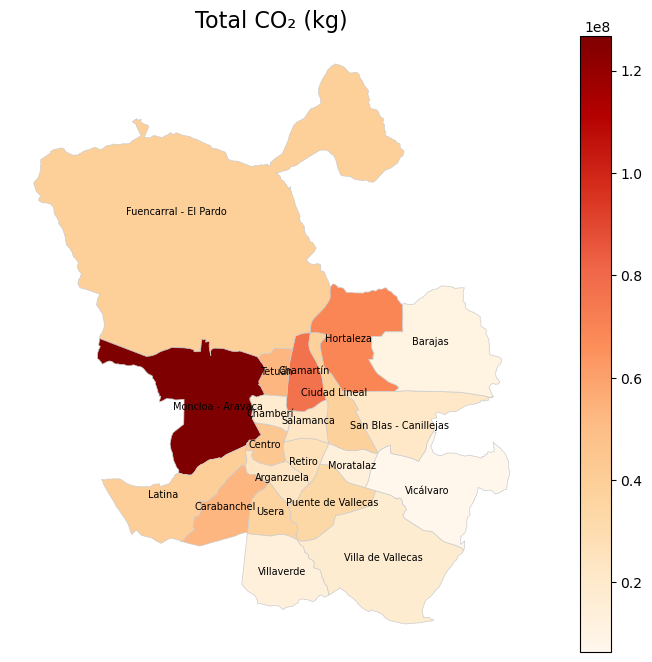

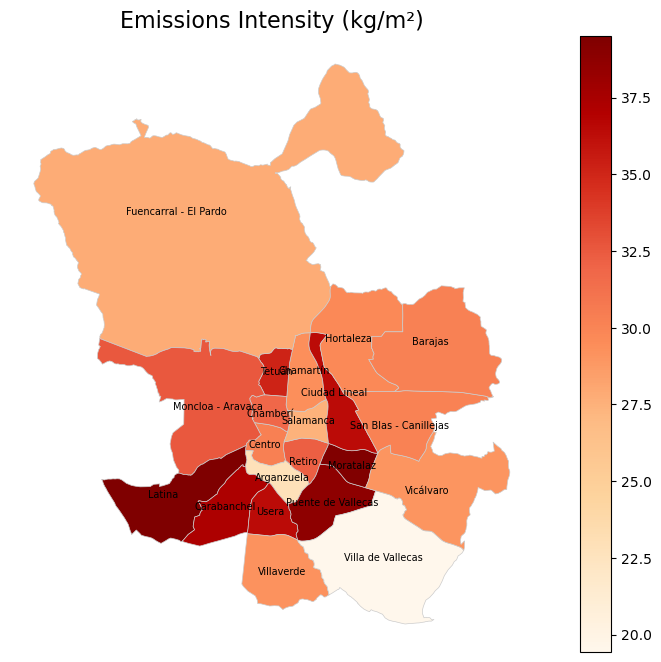

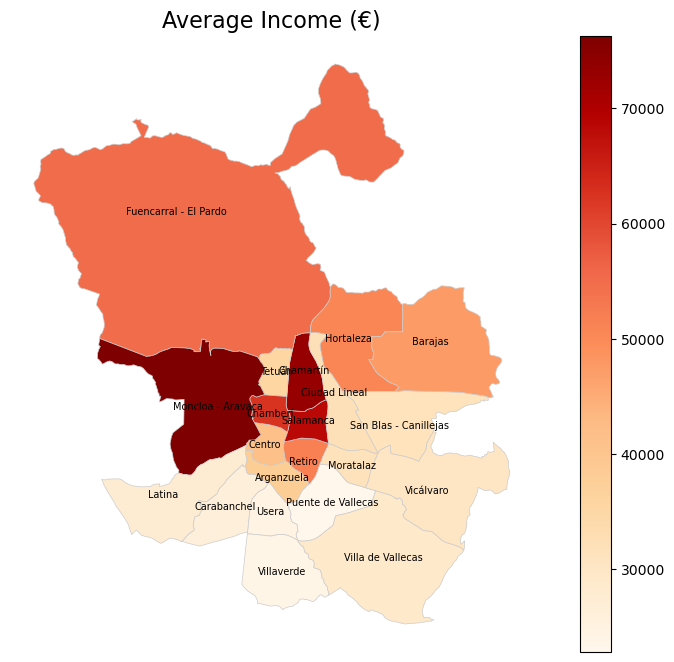

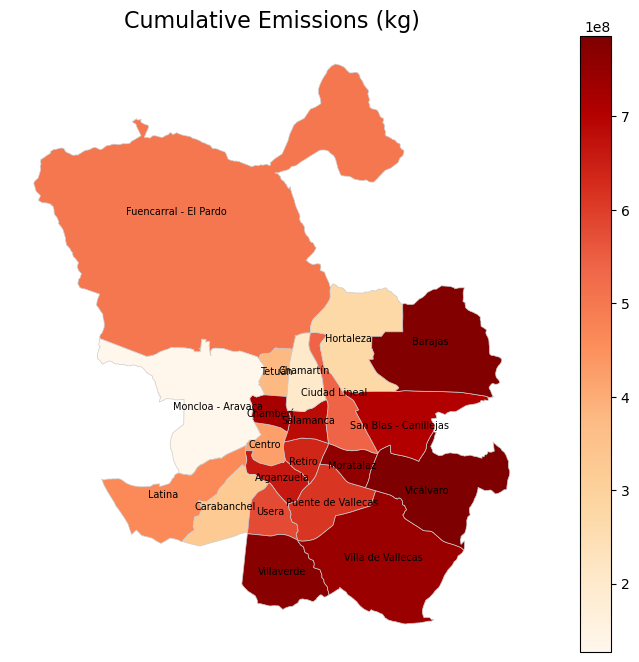

In [63]:
# Ensure centroids for labeling
gdf["centroid"] = gdf.geometry.representative_point()

def plot_map(gdf, column, title, cmap="OrRd"):
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    gdf.plot(column=column, cmap=cmap, legend=True, ax=ax, edgecolor="0.8", linewidth=0.5)
    
    # Add district names
    for idx, row in gdf.iterrows():
        ax.text(row["centroid"].x, row["centroid"].y, row["NOMBRE"],
                ha="center", va="center", fontsize=7, color="black")
    
    ax.set_title(title, fontsize=16)
    ax.axis("off")
    plt.show()

# Plot each metric separately
plot_map(gdf, "total_co2_kg", "Total CO₂ (kg)")
plot_map(gdf, "intensity_kg_m2", "Emissions Intensity (kg/m²)")
plot_map(gdf, "avg_income", "Average Income (€)")
plot_map(gdf, "cum_emissions", "Cumulative Emissions (kg)")

##  Why Low-Income Districts Are Prioritized  
### Por qué se priorizan los distritos de bajos ingresos

**ENGLISH**  
- Low-income households face **energy poverty**: they spend more on heating and often live in cold, inefficient homes.  
- These areas tend to have **older buildings** with poor insulation and outdated systems.  
- Public investment in these zones delivers **high impact**: better health, lower emissions, and social equity.  
- Aligns with EU and Spanish climate policies for a **just transition**.  
- Targeting high-emission, low-income districts ensures **fair and effective decarbonization**.

**ESPAÑOL**  
- Los hogares de bajos ingresos sufren **pobreza energética**: gastan más en calefacción y viven en viviendas frías e ineficientes.  
- Suelen tener **edificios antiguos**, mal aislados y con sistemas obsoletos.  
- La inversión pública en estas zonas genera **alto impacto**: mejora la salud, reduce emisiones y promueve la equidad social.  
- Está alineado con las políticas climáticas de la UE y España para una **transición justa**.  
- Priorizar distritos con **altas emisiones y bajos ingresos** garantiza una descarbonización **justa y eficaz**.